In [1]:
# Third-party
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb
from astropy import units as u
from astropy.modeling.models import Moffat1D

# Project
import artpop

# Load matplotlib style
plt.style.use('jpg.mplstyle')

In [2]:
phot_system = ['HST_ACSWF', 'HSC', 'SDSSugriz']
pixel_scale = {s: p for s, p in zip(phot_system, [0.05, 0.17, 0.4])}

xy_dim_arcsec = 70
xy_dim = {s: 2 * int(xy_dim_arcsec / pixel_scale[s] / 2) + 1 for s in phot_system}                                                                   
fwhm = {s: f for s, f in zip(phot_system, [0.1, 0.6, 1.4])}

In [3]:
log_age = 10.1
feh = -1.0
total_mass = 3e6 * u.Msun
r_s = 0.4 * u.kpc
distance = 5.0 * u.Mpc

In [4]:
src = artpop.MISTPlummerSSP(log_age, feh, phot_system, r_s, distance, 
                            xy_dim['SDSSugriz'], pixel_scale['SDSSugriz'], 
                            total_mass=total_mass)

In [5]:
def scale_xy(src, xy_0_init, xy_0_final, scale):
    x_0, y_0 = xy_0_init
    r = np.sqrt((src.x - x_0)**2 + (src.y - y_0)**2)
    theta_xy = np.arctan2(src.y - y_0, src.x - x_0)
    x_0, y_0 = xy_0_final
    _x = x_0 + scale * r * np.cos(theta_xy)
    _y = y_0 + scale * r * np.sin(theta_xy)
    return np.array([_x, _y]).T

HST_ACSWF 0.1125
HSC 0.3825
SDSSugriz 0.9
HST_ACSWF 0.1125
HSC 0.3825
SDSSugriz 0.9


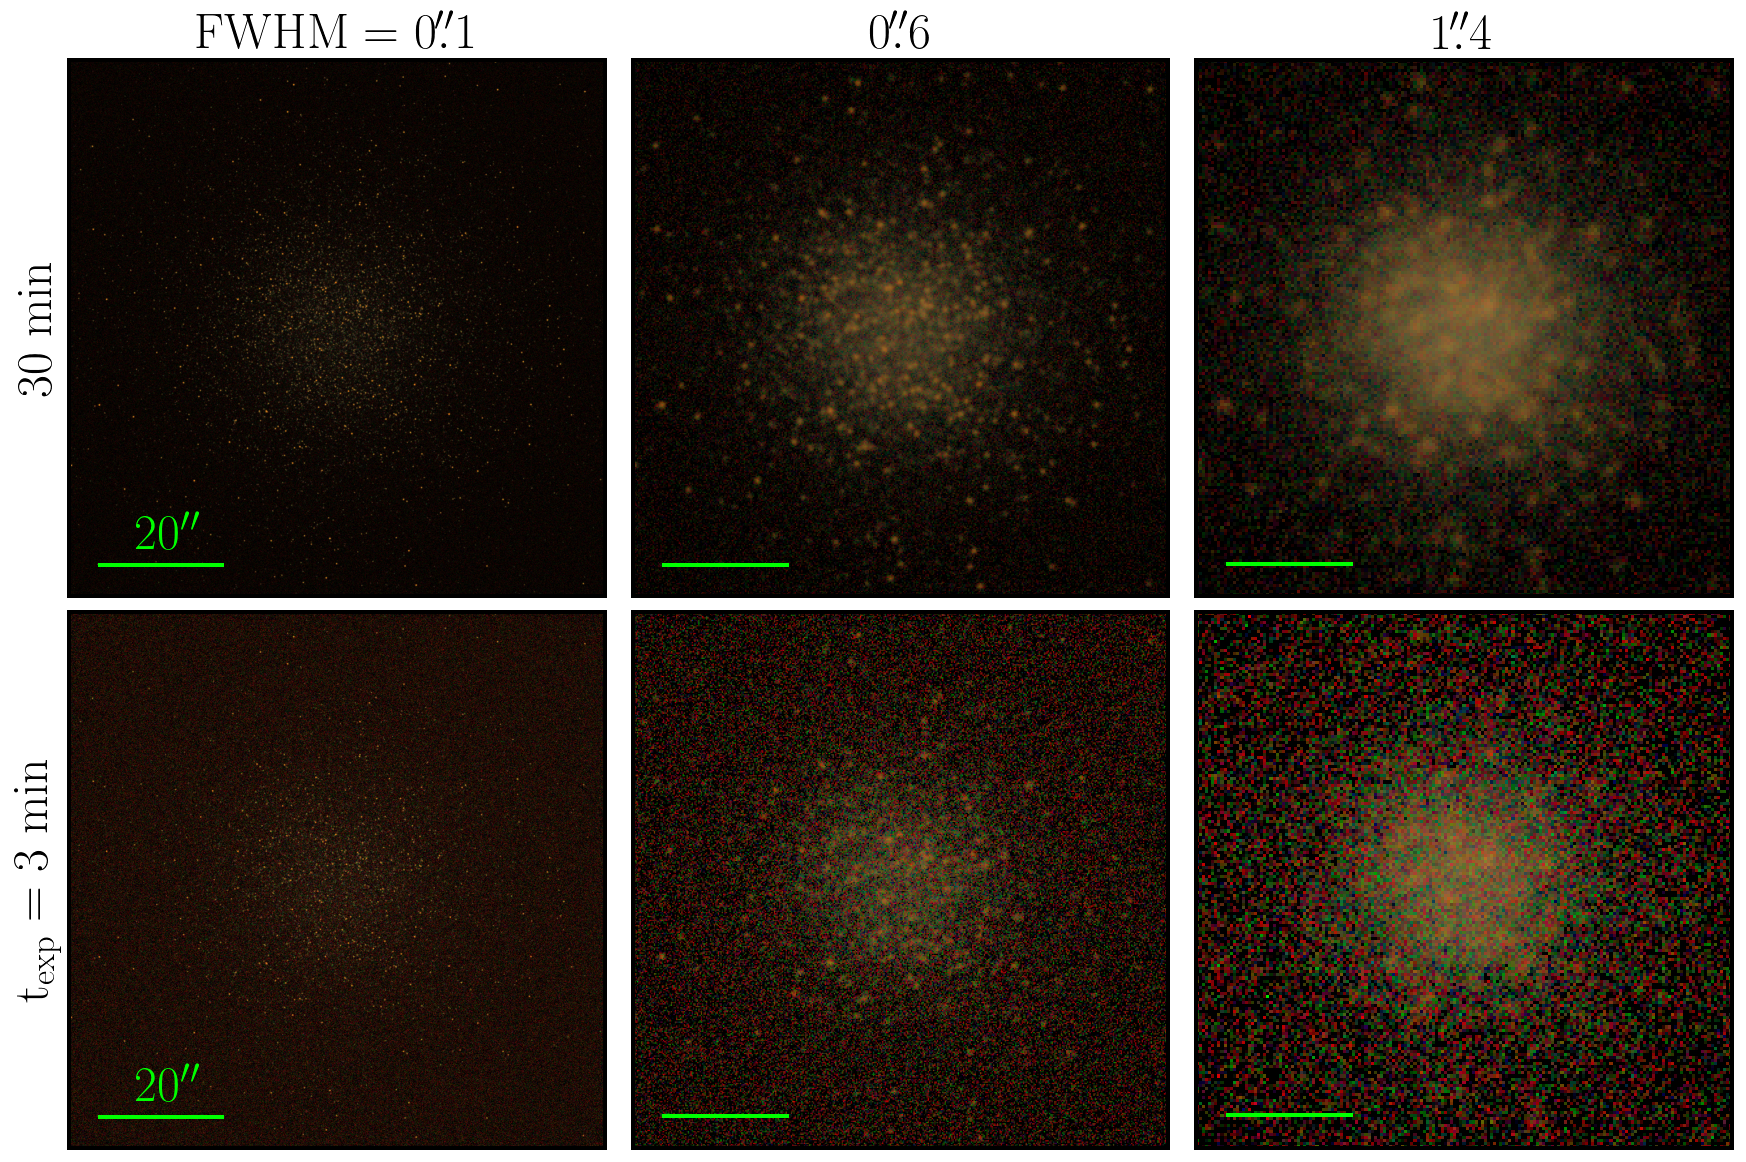

In [6]:
imager = artpop.ArtImager(phot_system, diameter=8, read_noise=3)

fig, axes = plt.subplots(2, 3, figsize=(15, 10),
                         subplot_kw=dict(xticks=[], yticks=[]))

fig.subplots_adjust(wspace=0.03, hspace=0.03)


xy_0_init = 2 * [xy_dim['SDSSugriz'] / 2]

exptimes = np.array([30, 3]) * u.min

for i, texp in enumerate(exptimes):

    for j, ps in enumerate(phot_system):

        ax = axes[i, j]
        
        xy_0_final = 2 * [xy_dim[ps] / 2]
        pixscale_ratio = pixel_scale['SDSSugriz'] / pixel_scale[ps]

        _xy = scale_xy(src, xy_0_init, xy_0_final, pixscale_ratio)
        _src = artpop.Source(_xy, src.mags, xy_dim[ps], pixel_scale[ps])
        psf= artpop.moffat_psf(fwhm[ps], pixel_scale[ps])

        image = []
        for b in 'irg': 
            sky_sb = dict(i=20, r=21, g=22)[b]
            obs = imager.observe(_src, f'SDSS_{b}', texp, sky_sb, psf)
            image.append(obs.image)

        stretch = dict(SDSSugriz=1.1, HSC=0.4, HST_ACSWF=0.06)[ps] 
        stretch = 0.9 / pixscale_ratio
        
        print(ps, stretch)
        rgb = make_lupton_rgb(*image, stretch=stretch)
        artpop.show_image(rgb, subplots=(fig, ax))


        x0, y0 = np.array([10, 10]) * pixscale_ratio

        ax.plot([x0, 20 / pixel_scale[ps]], [y0, y0], lw=2, c='lime')
        if ps == 'HST_ACSWF':
            ax.text(x0 + 9 / pixel_scale[ps], y0 + 40, '20$^{\prime\prime}$', fontsize=25, color='lime', ha='center')

fs = 25

axes[0, 0].set_ylabel(f'{exptimes[0].value:.0f} min', fontsize=fs)
axes[1, 0].set_ylabel('t$_\mathrm{exp} = ' + str(int(exptimes[1].value)) + ' $ min', fontsize=fs)

axes[0, 0].set_title('FWHM = $0.\!\!^{\prime\prime}1$', fontsize=fs)
axes[0, 1].set_title('$0.\!\!^{\prime\prime}6$', fontsize=fs)
axes[0, 2].set_title('$1.\!\!^{\prime\prime}4$', fontsize=fs);